# **Prompted Policy Search (ProPS): Reinforcement Learning through Linguistic and Numerical Reasoning in LLMs**

This notebook serves as a detailed tutorial on *[Prompted Policy Search (ProPS)](https://props-llm.github.io/)* (Zhou et al., 2025) a novel RL method that unifies numerical and linguistic reasoning within a single framework. ProPS places a large language model (LLM) at the center of the policy optimization loop; directly proposing policy updates based on both reward feedback and natural language input.

In this tutorial, we utilize a Large Language Model (LLM), specifically the Gemini 2.0/2.5 Flash, to perform Policy Search for a linear control policy within an OpenAI Gym reinforcement learning environment. Our focus will be on the MountainCar environment, where we aim to employ the Gemini family of models to discover the optimal parameters for a simple linear policy that enables the car to successfully reach its goal.

## **Environment: State and Action Variables**
<img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/refs/heads/master/static/images/mountain_car.gif" height="200"><img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/refs/heads/master/static/images/mountaincar_parameters.png" height="200">

The MountainCar environment presents a classic control challenge framed as a deterministic Markov Decision Process (MDP). In this setup, the environment's future state depends solely on the current state and the action taken, not on the history of preceding states. The term "deterministic" signifies that a specific action performed in a particular state will consistently lead to the identical next state and reward. The core task involves an underpowered car, initially placed randomly in the valley between two hills. The objective is to drive the car to the goal located at the top of the right hill. Due to the car's limited engine power, it cannot ascend the steep slope directly. Instead, the agent must learn a strategy of driving back and forth, building momentum to eventually conquer the hill.

Control over the car is exerted by applying an external force at each discrete timestep. This force is determined by an action value, $a$, chosen from the continuous range [-1, 1]. This action value is then scaled by a constant factor (0.0015) to yield the actual physical force applied. A positive action propels the car rightward, while a negative action pushes it leftward. At every timestep, the agent observes the environment's current state, which is captured by a two-dimensional vector:

\begin{bmatrix} x \\ v \end{bmatrix}

Here, $x$ represents the car's horizontal position (ranging from -1.2 to 0.6, with the goal at 0.5), and $v$ denotes its current velocity (ranging from -0.07 to 0.07). The environment provides a reward signal at each step; typically, this is -0.1 per step to encourage speed, plus a significant bonus (e.g., +100) upon reaching the goal.

## **Policy Representation**

In reinforcement learning, the agent's behavior is dictated by a "policy," which essentially maps observed states to appropriate actions. For this specific problem, we adopt a straightforward **linear policy**. This implies that the action is calculated as a linear combination of the current state variables (position and velocity). This policy is parameterized by a weight matrix (in this case, a 2x1 vector) denoted as:

$$θ = \begin{bmatrix} \theta_1 \\ \theta_2 \end{bmatrix}$$

Given a state $s^T = [x, v]$, the action is computed through a dot product:

$$π_θ = s^T θ = x \cdot θ_1 + v \cdot θ_2$$

The parameters $θ_1$ and $θ_2$ quantify the influence of the car's position and velocity, respectively, on the chosen action. The central aim of our optimization process is to determine the specific values for $θ_1$ and $θ_2$ that result in the highest possible total reward accumulated over an entire episode.

## **Optimization Strategy: LLM-Driven Policy Search**

The fundamental objective is to identify the optimal policy parameters $π_θ$ that maximize the cumulative reward $R$ gathered over a complete episode, which consists of a sequence of steps from the start until termination (either reaching the goal or hitting the maximum step limit, e.g., 1000). This task is formally known as **Policy Search**. Mathematically, we seek to solve:
$$ \max_{θ} \mathbb{E}\left[ \sum_{t=0}^{T} r_t \right]$$

where $r_t$ is the reward at timestep $t$ and $T$ is the episode length.

To facilitate this optimization, we utilize a "Replay Buffer." After each episode concludes, having been run with the current parameters $θ$, the total reward $R$ is calculated. This $(θ, R)$ pair is then stored in the buffer. We approach the relationship between the policy parameters $π_θ$ and the resulting reward $R$ as a **black-box function**. This means the optimizer, which is the LLM in our case, operates without explicit knowledge of the MountainCar environment's internal physics or reward structure. It only observes the input parameters $θ$ and the corresponding output reward $R$.

## **LLM as the Optimizer**

We harness the capabilities of the Gemini models to conduct this black-box optimization. The LLM is instructed via a prompt to function as an optimization assistant. The process begins with a "warmup" phase, where several episodes are run using randomly selected parameters $π_θ$. The resulting $(θ, R)$ pairs populate the Replay Buffer, providing initial data. Subsequently, the LLM is presented with a detailed prompt containing the optimization goal, the historical data from the Replay Buffer, output format instructions, and guidance on balancing exploration (trying novel parameters) versus exploitation (refining promising parameters), adapting this balance as the optimization progresses. Based on this prompt and the historical context (enabling in-context learning), the LLM proposes a new set of parameters $θ$ anticipated to yield improved rewards.

<br />
<p style="text-align:center;">
<img src="https://github.com/k-pratyush/props-llm-examples/blob/main/static/props_approach_overview.jpeg?raw=1" alt="image" width=350>
</p>
Figure (a): Optimization Approach

<br />
<br />

The agent's policy is then updated with these suggested parameters, and one or more evaluation episodes are executed in the environment. The cumulative reward obtained from these evaluations is recorded, and the new $(π_θ, \text{cumulative } R)$ pair is added to the Replay Buffer. This cycle of prompting the LLM, receiving parameter suggestions, evaluating the updated policy, and updating the buffer is repeated for a predetermined number of episodes (e.g., 400), allowing the LLM to iteratively refine the policy parameters towards optimality. The prompt design treats the task purely as optimizing an unknown function $f(θ_1, θ_2) = R$, guiding the LLM with hints on step size and search ranges but without revealing the underlying simulation details.

## **Code Overview**

The implementation follows a modular design. The **World** component (`MountaincarContinuousActionWorld`) wraps the standard Gymnasium environment, managing state transitions, reward calculations, and episode termination. The **Agent** component (`MountaincarContinuousActionLLMNumOptimAgent`) integrates the learning elements. It includes the **`LinearPolicy`** module, which stores the policy weights ($θ_1, θ_2$) and computes actions based on states. It also contains the **`EpisodeRewardBufferNoBias`** module, responsible for maintaining the Replay Buffer of (weights, reward) pairs. Finally, the **`LLMBrain`** module orchestrates all interactions with the LLM, including prompt generation using Jinja2 templates, API communication (handling both OpenAI and Gemini models), and parsing the LLM's responses to extract the suggested new parameters.

## **Hyperparameters**

Several hyperparameters govern the experiment's execution. `NUM_EPISODES` (e.g., 400) sets the total number of optimization iterations. `RENDER_MODE` controls environment visualization. `MAX_TRAJ_COUNT` (e.g., 1000) defines the Replay Buffer size, influencing the historical context available to the LLM. `MAX_TRAJ_LENGTH` (e.g., 1000) sets the maximum steps per episode. `LLM_MODEL_NAME` specifies the LLM used. `NUM_EVALUATION_EPISODES` (e.g., 20) determines how many runs are averaged to evaluate a new policy. `WARMUP_EPISODES` (e.g., 20) sets the number of initial random runs. `SEARCH_STD` (e.g., 1.0) provides a hint to the LLM regarding the step size for parameter exploration.

## **Training Loop**
<p style="text-align:center;">
<img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/1daf690cda61281b95befc6d65893bc0417c0d0e/static/images/mountaincar_loop.svg" alt="image">
</p>
Figure (b): Code Overview

<br />
<br />

The `run_training_loop` function orchestrates the process. It initializes the World and Agent components. It performs the initial warmup runs if necessary, populating the replay buffer. Then, it enters the main loop, iterating `NUM_EPISODES` times. In each iteration, it interacts with the LLM (`agent.train_policy`) to get updated policy parameters based on the replay buffer history. It then evaluates the performance of this new policy over `NUM_EVALUATION_EPISODES` (`agent.evaluate_policy`), calculates the cumulative reward, and adds the new (parameters, cumulative reward) pair back into the replay buffer. Logging occurs at each step.

## **Output Structure**

The training process generates structured logs. A main log directory contains subdirectories for each episode (`episode_*`) and potentially a `warmup/` directory. Each episode directory stores logs of evaluation trajectories, the parameters suggested by the LLM for that episode (`parameters.txt`), and the full LLM interaction including its reasoning (`parameters_reasoning.txt`). The final notebook cells typically include code for visualizing the learned policy in action and plotting the reward curve over episodes, illustrating the learning progress.

## **Before Running the Demo, Follow the Instructions Below**
To run the full experiment:
1. Ensure all dependencies are imported and installed.
2.	Visit Google AI Studio (https://aistudio.google.com/) to obtain your Gemini API key.
3.	Once API key is generated, copy and paste it into the demo when prompted.

#### **If having trouble creating an API Key, follow the link below for instructions:**
* #### **[Instructions on How to Obtain a Gemini API Key](https://docs.google.com/document/d/17pgikIpvZCBgcRh4NNrcee-zp3Id0pU0vq2SG52KIGE/edit?usp=sharing)**



In [ ]:
#@title **Install and Import Necessary Libraries**
import re
import os
import time
from decimal import Decimal
from collections import deque
import matplotlib.pyplot as plt
from IPython import display
import traceback
import numpy as np
from IPython.display import display, update_display

import numpy as np
import gymnasium as gym
from jinja2 import Template
from google import genai
import getpass
import ipywidgets as widgets
import imageio

In [ ]:
#@title **Setting Up Gemini Client**
apikey = getpass.getpass("Enter your Gemini API Key: ")

Enter your Gemini API Key: ··········


In [ ]:
#@title **Choose a Model**
model_dropdown = widgets.Dropdown(
    options=[
        ("Gemini 2.5 Flash", "gemini-2.5-flash"),
        ("Gemini 2.0 Flash", "gemini-2.0-flash")
    ],
    description="Model:",
    value="gemini-2.5-flash",
    style={'description_width': 'initial'}
)

confirm_button = widgets.Button(
    description="Confirm Selection"
)

output = widgets.Output()

model_name = None

def on_confirm_click(b):
    global model_name, batch_size

    model_name = model_dropdown.value

    with output:
        output.clear_output()
        print(f"\nSelected model: {model_name}")

confirm_button.on_click(on_confirm_click)

display(model_dropdown, confirm_button, output)

Dropdown(description='Model:', options=(('Gemini 2.5 Flash', 'gemini-2.5-flash'), ('Gemini 2.0 Flash', 'gemini…

Button(description='Confirm Selection', style=ButtonStyle())

Output()

This cell introduces and lists the key hyperparameters that control the execution and behavior of the reinforcement learning experiment. Hyperparameters are settings that are not learned by the agent itself but are defined by the user before the training process begins. They significantly influence the learning process and the performance of the agent.

`NUM_EPISODES` (e.g., 400): Defines the total number of optimization iterations or training episodes the agent will go through. A higher number allows for more learning but increases computation time.

`RENDER_MODE` (e.g., None): Controls how the environment is visualized during execution. Options typically include 'human' (real-time window), 'rgb_array' (returns a pixel array, useful for recording), or None (no visualization, fastest for training).

`MAX_TRAJ_COUNT` (e.g., 1000): Sets the maximum size of the Replay Buffer. This buffer stores (policy parameters, reward) pairs, and its size determines how much historical data the LLM has access to when making decisions.

`MAX_TRAJ_LENGTH` (e.g., 1000): Specifies the maximum number of steps allowed in a single episode. If the agent doesn't reach a terminal state within these steps, the episode is truncated.

`LLM_MODEL_NAME` (e.g., "gemini-2.5-flash-preview-04-17"): Specifies which Large Language Model will be used as the optimizer. The comment lists several compatible models from OpenAI and Google.
NUM_EVALUATION_EPISODES (e.g., 20): Determines how many times a newly proposed policy is run in the environment to get an average measure of its performance. Averaging helps to reduce variance in the reward signal.

`WARMUP_EPISODES` (e.g., 20): Sets the number of initial episodes run with randomly generated policy parameters. This "warmup" phase populates the Replay Buffer with some initial data points before the LLM starts optimizing.

`SEARCH_STD` (e.g., 1.0): Provides a hint to the LLM regarding the standard deviation or step size it should consider when exploring new parameter values, especially during the initial exploration phase.

In [ ]:
#@title **Key Hyperparameters**
NUM_EPISODES=200 # Total number of episodes to train for
RENDER_MODE=None # Choose from 'human', 'rgb_array', or None
MAX_TRAJ_COUNT=1000 # Maximum number of trajectories to store in buffer for prompt
MAX_TRAJ_LENGTH=1000 # Maximum number of steps in a trajectory
LLM_MODEL_NAME="gemini-2.0-flash" # LLM for optimization, choose from "o1-preview", "gpt-4o", "gemini-2.0-flash-exp", "gpt-4o-mini", "gemini-1.5-flash", "gemini-1.5-flash-8b", "gemini-1.5-pro", "gemini-2.5-pro-preview-05-06", "gemini-2.5-flash-preview-04-17", "o3-mini-2025-01-31", "gpt-4o-2024-11-20", "gpt-4o-2024-08-06", "claude-3-7-sonnet-20250219"

NUM_EVALUATION_EPISODES=20 # Number of episodes to generate agent rollouts for evaluation
WARMUP_EPISODES=20 # Number of randomly generated initial episodes
SEARCH_STD=1.0 # Step size for LLM to search for optimal parameters during exploration

The below cell defines the template for the black box optimization prompt. The prompt template uses variables defined in the code for setting the number of parameters required to optimize, the global optimum of the function, step size, current step count and the history of (parameter, reward) tuples.

In [ ]:
#@title **Black Box Optimization Prompt Example**
LLM_SI_TEMPLATE_STRING = """
You are good global optimizer, helping me find the global maximum of a mathematical function f(params).
I will give you the function evaluation and the current iteration number at each step.
Your goal is to propose input values that efficiently lead us to the global maximum within a limited number of iterations (400).

# Regarding the parameters **params**:
**params** is an array of {{ rank }} float numbers.
**params** values are in the range of [-6.0, 6.0] with 1 decimal place.

# Here's how we'll interact:
1. I will first provide MAX_STEPS (400) along with a few training examples.
2. You will provide your response in the following exact format:
    * Line 1: a new input 'params[0]: , params[1]: , params[2]: ,..., params[{{ rank - 1 }}]: ', aiming to maximize the function's value f(params).
    Please propose params values in the range of [-6.0, 6.0], with 1 decimal place.
    * Line 2: detailed explanation of why you chose that input.
3. I will then provide the function's value f(params) at that point, and the current iteration.
4. We will repeat steps 2-3 until we reach the maximum number of iterations.

# Remember:
1. **Do not propose previously seen params.**
2. **The global optimum should be around {{ optimum }}.** If you are below that, this is just a local optimum. You should explore instead of exploiting.
3. Search both positive and negative values. **During exploration, use search step size of {{ step_size }}**.


Next, you will see examples of params and f(params) pairs.
{{ episode_reward_buffer_string }}

Now you are at iteration {{step_number}} out of 400. Please provide the results in the indicated format. Do not provide any additional texts."""


llm_si_template = Template(LLM_SI_TEMPLATE_STRING)
llm_output_conversion_template = llm_si_template

## **World**

The `ContinualSpaceGeneralWorld` is a wrapper class over the Gymnasium environments to give standardized interface for the agents.

In [ ]:
#@title **MountainCarContinuous-v0**
# https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/

import gymnasium as gym


class ContinualSpaceGeneralWorld():
    def __init__(
        self,
        gym_env_name,
        render_mode,
        max_traj_length=1000,
    ):
        assert render_mode in ["human", "rgb_array", None]

        if gym_env_name == "gym_navigation:NavigationTrack-v0":
            self.env = gym.make(
                gym_env_name,
                render_mode=render_mode,
                track_id=1,
            )
        elif gym_env_name == "maze-sample-3x3-v0":
            self.env = gym.make(
                gym_env_name,
                enable_render=render_mode,
            )
        else:
            self.env = gym.make(gym_env_name, render_mode=render_mode)
        self.gym_env_name = gym_env_name
        self.render_mode = render_mode
        self.steps = 0
        self.accu_reward = 0
        self.max_traj_length = max_traj_length
        if isinstance(self.env.action_space, gym.spaces.Discrete):
            self.discretize = True
        else:
            self.discretize = False

    def reset(self, new_reward=False):
        """ This method resets the environment to its initial state.
        If `new_reward` is True, it initializes the environment with a different reward structure.
        """
        del self.env
        if not new_reward:
            self.env = gym.make(self.gym_env_name, render_mode=self.render_mode)
        else:
            self.env = gym.make(self.gym_env_name, render_mode=self.render_mode, healthy_reward=0)

        state, _ = self.env.reset()
        self.steps = 0
        self.accu_reward = 0
        return state

    def step(self, action):
        """
        This method executes a step in the environment with the given action.
        It updates the environment state, accumulates the reward, and checks if the episode is done.
        """
        self.steps += 1
        action = action[0]
        state, reward, terminated, truncated, _ = self.env.step(action)
        self.accu_reward += reward

        if self.steps >= self.max_traj_length or terminated or truncated:
            done = True
        else:
            done = False

        return state, reward, done

    def get_accu_reward(self):
        """
        This method returns the accumulated reward for the current episode.
        """
        return self.accu_reward

## **Sub Modules**

`EpisodeRewardBufferNoBias`: Store and manage collection of (policy parameters and reward) pairs, acting as the replay buffer.

`LinearPolicy`: Implements a linear policy where the action is computed as a dot product of the state and weights, plus a bias term: $a = s^T W + b$.

`LinearPolicyNoBias`: Implements a linear policy without a bias term: $a = s^T W$.

`LLMBrain`: Coordinates with the LLM to get new parameters for the policy based on existing policy (parameter, reward) pairs.

In [ ]:
#@title **Details**
class EpisodeRewardBufferNoBias:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, weights: np.ndarray, reward):
        self.buffer.append((weights, reward))

    def sort(self):
        self.buffer = deque(sorted(self.buffer, key=lambda x: x[1], reverse=False), maxlen=self.buffer.maxlen)

    def __str__(self):
        buffer_table = "Parameters | Reward\n"
        for weights, reward in self.buffer:
            buffer_table += f"{weights.reshape(1, -1)} | {reward}\n"
        return buffer_table

    def load(self, folder):
        # Find all episode files
        all_files = [os.path.join(folder, x) for x in os.listdir(folder) if x.startswith('warmup_rollout')]
        all_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

        # Load parameters from all episodes
        for filename in all_files:
            with open(filename, 'r') as f:
                lines = f.readlines()
                parameters = []
                for line in lines:
                    if "parameter ends" in line:
                        break
                    try:
                        parameters.append([float(x) for x in line.split(',')])
                    except:
                        continue
                parameters = np.array(parameters)

                rewards = []
                for line in lines:
                    if "Total reward" in line:
                        try:
                            rewards.append(float(line.split()[-1]))
                        except:
                            continue
                rewards_mean = np.mean(rewards)
                self.add(parameters, rewards_mean)
                f.close()
        print(self)


class LinearPolicy():
    """
    Linear policy for continuous action space. The policy is represented as a (2,1) matrix of weights.
    Next action is calculated as the dot product of the state and the weight matrix.
    state.T * weight + bias -> action
    (1,2) * (2,1) + (1,1) -> (1,1)
    """
    def __init__(self, dim_states, dim_actions):

        self.dim_states =dim_states
        self.dim_actions = dim_actions

        self.weight = np.random.rand(self.dim_states, self.dim_actions)
        self.bias = np.random.rand(1, self.dim_actions)

    def initialize_policy(self):
        self.weight = np.round(np.random.normal(0., 3., size=(self.dim_states, self.dim_actions)), 1)
        self.bias = np.round(np.random.normal(0., 3., size=(1, self.dim_actions)), 1)

    def get_action(self, state):
        state = state.T
        return np.matmul(state, self.weight) + self.bias

    def __str__(self):
        output = "Weights:\n"
        for w in self.weight:
            output += ", ".join([str(i) for i in w])
            output += "\n"

        output += "Bias:\n"
        for b in self.bias:
            output += ", ".join([str(i) for i in b])
            output += "\n"

        return output

    def update_policy(self, weight_and_bias_list):
        if weight_and_bias_list is None:
            return

        weight_and_bias_list = np.array(weight_and_bias_list).reshape(self.dim_states + 1, self.dim_actions)
        self.weight = np.array(weight_and_bias_list[:-1])
        self.bias = np.expand_dims(np.array(weight_and_bias_list[-1]), axis=0)

    def get_parameters(self):
        parameters = np.concatenate((self.weight, self.bias), axis=0)
        return parameters

class LinearPolicyNoBias():
    def __init__(self, dim_states, dim_actions):

        self.dim_states = dim_states
        self.dim_actions = dim_actions

        self.weight = np.random.rand(self.dim_states, self.dim_actions)

    def initialize_policy(self):
        self.weight = np.round((np.random.rand(self.dim_states, self.dim_actions) - 0.5) * 6, 1)

    def get_action(self, state):
        state = state.T
        return np.matmul(state, self.weight)

    def __str__(self):
        output = "Weights:\n"
        for w in self.weight:
            output += ", ".join([str(i) for i in w])
            output += "\n"

        return output

    def update_policy(self, weight_and_bias_list):
        if weight_and_bias_list is None:
            return
        self.weight = np.array(weight_and_bias_list)
        self.weight = self.weight.reshape(-1)
        for i in range(len(self.weight)):
            self.weight[i] = Decimal(self.weight[i]).normalize()

        self.weight = self.weight.reshape(
            self.dim_states, self.dim_actions
        )

    def get_parameters(self):
        return self.weight


class LLMBrain:
    def __init__(
        self,
        llm_si_template: Template,
        llm_output_conversion_template: Template,
        llm_model_name: str,
    ):
        self.llm_si_template = llm_si_template
        self.llm_output_conversion_template = llm_output_conversion_template
        self.llm_conversation = []
        assert llm_model_name in [
            "gemini-2.0-flash"
        ]
        self.llm_model_name = llm_model_name
        if "gemini" in llm_model_name:
            self.model_group = "gemini"
            self.client = genai.Client(api_key=apikey)
        elif "claude" in llm_model_name:
            self.model_group = "anthropic"
            self.client = anthropic.Client(api_key=os.environ["ANTHROPIC_API_KEY"])
        else:
            self.model_group = "openai"
            self.client = OpenAI()

    def reset_llm_conversation(self):
        self.llm_conversation = []

    def add_llm_conversation(self, text, role):
        if self.model_group == "openai":
            self.llm_conversation.append({"role": role, "content": text})
        elif self.model_group == "anthropic":
            self.llm_conversation.append({"role": role, "content": text})
        else:
            self.llm_conversation.append({"role": role, "parts": text})

    def query_llm(self):
        for attempt in range(10):
            try:
                if self.model_group == "openai":
                    completion = self.client.chat.completions.create(
                        model=self.llm_model_name,
                        messages=self.llm_conversation,
                    )
                    response = completion.choices[0].message.content
                elif self.model_group == "anthropic":
                    message = self.client.messages.create(
                        model=self.llm_model_name,
                        messages=self.llm_conversation,
                        max_tokens=1024,
                    )
                    response = message.content[0].text
                else:
                    prompt = self.llm_conversation[-1]["parts"]
                    response = self.client.models.generate_content(
                        model=model_name,
                        contents=[prompt]
                    )
                    response = response.text
            except Exception as e:
                print(f"Error: {e}")
                print("Retrying...")
                if attempt == 9:
                    raise Exception("Failed")
                else:
                    print("Waiting for 60 seconds before retrying...")
                    time.sleep(60)

            if self.model_group == "openai":
                # add the response to self.llm_conversation
                self.add_llm_conversation(response, "assistant")
            else:
                self.add_llm_conversation(response, "model")

            return response


    def parse_parameters(self, parameters_string):
        new_parameters_list = []

        # Update the Q-table based on the new Q-table
        for row in parameters_string.split("\n"):
            if row.strip().strip(","):
                try:
                    parameters_row = [
                        float(x.strip().strip(",")) for x in row.split(",")
                    ]
                    new_parameters_list.append(parameters_row)
                except Exception as e:
                    print(e)

        return new_parameters_list


    def llm_update_parameters_num_optim(
        self,
        episode_reward_buffer,
        parse_parameters,
        step_number,
        rank=None,
        optimum=None,
        search_step_size=0.1,
        actions=None,
    ):
        self.reset_llm_conversation()

        system_prompt = self.llm_si_template.render(
            {
                "episode_reward_buffer_string": str(episode_reward_buffer),
                "step_number": str(step_number),
                "rank": rank,
                "optimum": str(optimum),
                "step_size": str(search_step_size),
                "actions": actions,
            }
        )

        self.add_llm_conversation(system_prompt, "user")

        api_start_time = time.time()
        new_parameters_with_reasoning = self.query_llm()
        api_time = time.time() - api_start_time
        new_parameters_list = parse_parameters(new_parameters_with_reasoning)

        return (
            new_parameters_list,
            "system:\n"
            + system_prompt
            + "\n\n\nLLM:\n"
            + new_parameters_with_reasoning,
            api_time,
        )

## **Agent**

The below cell defines the core agent wrapper. It is responsibe for managing the policy, interacting with the world and coordinating with the LLMBrain to learn.

In [ ]:
#@title **Core Agent Wrapper**
class LLMNumOptimAgent:
    def __init__(
        self,
        logdir,
        dim_action,
        dim_state,
        max_traj_count,
        max_traj_length,
        llm_si_template,
        llm_output_conversion_template,
        llm_model_name,
        num_evaluation_episodes,
        bias,
        optimum,
        search_step_size,
    ):
        self.start_time = time.process_time()
        self.api_call_time = 0
        self.total_steps = 0
        self.total_episodes = 0
        self.dim_action = dim_action
        self.dim_state = dim_state
        self.bias = bias
        self.optimum = optimum
        self.search_step_size = search_step_size

        if not self.bias:
            param_count = dim_action * dim_state
        else:
            param_count = dim_action * dim_state + dim_action
        self.rank = param_count

        # Initialize the policy and replay buffer
        if not self.bias:
            self.policy = LinearPolicyNoBias(
                dim_actions=dim_action, dim_states=dim_state
            )
        else:
            self.policy = LinearPolicy(dim_actions=dim_action, dim_states=dim_state)
        self.replay_buffer = EpisodeRewardBufferNoBias(max_size=max_traj_count)
        self.llm_brain = LLMBrain(
            llm_si_template, llm_output_conversion_template, llm_model_name
        )
        self.logdir = logdir
        self.num_evaluation_episodes = num_evaluation_episodes
        self.training_episodes = 0

        if self.bias:
            self.dim_state += 1

    def rollout_episode(self, world, logging_file, record=True):
        """Simulates an episode in the environment using the current policy."""
        state = world.reset()
        state = np.expand_dims(state, axis=0)
        logging_file.write(
            f"{', '.join([str(x) for x in self.policy.get_parameters().reshape(-1)])}\n"
        )
        logging_file.write(f"parameter ends\n\n")
        logging_file.write(f"state | action | reward\n")
        done = False
        step_idx = 0
        while not done:
            action = self.policy.get_action(state.T)
            action = np.reshape(action, (1, self.dim_action))
            if world.discretize:
                action = np.argmax(action)
                action = np.array([action])
            next_state, reward, done = world.step(action)
            logging_file.write(f"{state.T[0]} | {action[0]} | {reward}\n")
            state = next_state
            step_idx += 1
            self.total_steps += 1
        logging_file.write(f"Total reward: {world.get_accu_reward()}\n")
        self.total_episodes += 1
        if record:
            self.replay_buffer.add(
                self.policy.get_parameters(), world.get_accu_reward()
            )
        return world.get_accu_reward()

    def random_warmup(self, world, logdir, num_episodes):
        for episode in range(num_episodes):
            self.policy.initialize_policy()
            # Run the episode and collect the trajectory
            print(f"Rolling out warmup episode {episode}...")
            logging_filename = f"{logdir}/warmup_rollout_{episode}.txt"
            logging_file = open(logging_filename, "w")
            result = self.rollout_episode(world, logging_file)
            print(f"Result: {result}")

    def train_policy(self, world, logdir):
        """Core method to train single iteration of the policy using LLM optimization."""

        def parse_parameters(input_text):
            # This regex looks for integers or floating-point numbers (including optional sign)
            s = input_text.split("\n")[0]
            print("response:", s)
            pattern = re.compile(r"params\[(\d+)\]:\s*([+-]?\d+(?:\.\d+)?)")
            matches = pattern.findall(s)

            # Convert matched strings to float (or int if you prefer to differentiate)
            results = []
            for match in matches:
                results.append(float(match[1]))
            print(results)
            assert len(results) == self.rank
            return np.array(results).reshape(-1)

        def str_nd_examples(replay_buffer: EpisodeRewardBufferNoBias, n):

            all_parameters = []
            for weights, reward in replay_buffer.buffer:
                parameters = weights
                all_parameters.append((parameters.reshape(-1), reward))

            text = ""
            for parameters, reward in all_parameters:
                l = ""
                for i in range(n):
                    l += f"params[{i}]: {parameters[i]:.5g}; "
                fxy = reward
                l += f"f(params): {fxy:.2f}\n"
                text += l
            return text

        # Update the policy using llm_brain, q_table and replay_buffer
        print("Updating the policy...")
        new_parameter_list, reasoning, api_time = self.llm_brain.llm_update_parameters_num_optim(
            str_nd_examples(self.replay_buffer, self.rank),
            parse_parameters,
            self.training_episodes,
            self.rank,
            self.optimum,
            self.search_step_size
        )
        self.api_call_time += api_time

        print(self.policy.get_parameters().shape)
        print(new_parameter_list.shape)
        self.policy.update_policy(new_parameter_list)
        print(self.policy.get_parameters().shape)
        logging_q_filename = f"{logdir}/parameters.txt"
        logging_q_file = open(logging_q_filename, "w")
        logging_q_file.write(str(self.policy))
        logging_q_file.close()
        q_reasoning_filename = f"{logdir}/parameters_reasoning.txt"
        q_reasoning_file = open(q_reasoning_filename, "w")
        q_reasoning_file.write(reasoning)
        q_reasoning_file.close()
        print("Policy updated!")

        # Run the episode and collect the trajectory
        print(f"Rolling out episode {self.training_episodes}...")
        logging_filename = f"{logdir}/training_rollout.txt"
        logging_file = open(logging_filename, "w")
        results = []
        for idx in range(self.num_evaluation_episodes):
            if idx == 0:
                result = self.rollout_episode(world, logging_file, record=False)
            else:
                result = self.rollout_episode(world, logging_file, record=False)
            results.append(result)
        print(f"Results: {results}")
        result = np.mean(results)
        self.replay_buffer.add(new_parameter_list, result)

        self.training_episodes += 1

        _cpu_time = time.process_time() - self.start_time
        _api_time = self.api_call_time
        _total_episodes = self.total_episodes
        _total_steps = self.total_steps
        _total_reward = result
        return _cpu_time, _api_time, _total_episodes, _total_steps, _total_reward


    def evaluate_policy(self, world, logdir):
        results = []
        for idx in range(self.num_evaluation_episodes):
            logging_filename = f"{logdir}/evaluation_rollout_{idx}.txt"
            logging_file = open(logging_filename, "w")
            result = self.rollout_episode(world, logging_file, record=False)
            results.append(result)
        return results

The below cell orchestrates the entire training process from initialization to completion. The `run_training_loop` function starts with initialization the world, and the agent instances. Then, it creates a set of warmup episodes to pass in as initial replay buffer to the optimizer. The code then runs the training loop for specified number of episodes and optimizes the policy parameters.

In [ ]:
#@title **Training Loop**
def run_training_loop(
    num_episodes,
    gym_env_name,
    render_mode,
    logdir,
    dim_actions,
    dim_states,
    max_traj_count,
    max_traj_length,
    llm_model_name,
    num_evaluation_episodes,
    warmup_episodes,
    warmup_dir,
    bias=None,
    rank=None,
    optimum=100,
    search_step_size=SEARCH_STD,
):
    world = ContinualSpaceGeneralWorld(
        gym_env_name,
        render_mode,
        max_traj_length,
    )

    agent = LLMNumOptimAgent(
        logdir,
        dim_actions,
        dim_states,
        max_traj_count,
        max_traj_length,
        llm_si_template,
        llm_output_conversion_template,
        llm_model_name,
        num_evaluation_episodes,
        bias,
        optimum,
        search_step_size,
    )
    print('init done')

    if not warmup_dir:
        warmup_dir = f"{logdir}/warmup"
        os.makedirs(warmup_dir, exist_ok=True)
        agent.random_warmup(world, warmup_dir, warmup_episodes)
    else:
        agent.replay_buffer.load(warmup_dir)

    overall_log_file = open(f"{logdir}/overall_log.txt", "w")
    overall_log_file.write("Iteration, CPU Time, API Time, Total Episodes, Total Steps, Total Reward\n")
    overall_log_file.flush()
    for episode in range(num_episodes):
        print("-----------------------------------------------------------------------------------------------------------")
        print(f"Episode: {episode}")
        # create log dir
        curr_episode_dir = f"{logdir}/episode_{episode}"
        print(f"Creating log directory: {curr_episode_dir}")
        os.makedirs(curr_episode_dir, exist_ok=True)

        for trial_idx in range(5):
            try:
                cpu_time, api_time, total_episodes, total_steps, total_reward = agent.train_policy(world, curr_episode_dir)
                overall_log_file.write(f"{episode + 1}, {cpu_time}, {api_time}, {total_episodes}, {total_steps}, {total_reward}\n")
                overall_log_file.flush()
                print(f"{trial_idx + 1}th trial attempt succeeded in training")
                break
            except Exception as e:
                print(
                    f"{trial_idx + 1}th trial attempt failed with error in training: {e}"
                )
                traceback.print_exc()

                if trial_idx == 4:
                    print(f"All {trial_idx + 1} trials failed. Train terminated")
                    exit(1)
                continue
    overall_log_file.close()

In [ ]:
#@title **Run the Training Loop**
run_training_loop(
    num_episodes=NUM_EPISODES,
    gym_env_name="MountainCarContinuous-v0",
    render_mode=RENDER_MODE,
    logdir="logs/mountaincar_continuous_tutorial",
    dim_actions=1,
    dim_states=2,
    max_traj_count=MAX_TRAJ_COUNT,
    max_traj_length=MAX_TRAJ_LENGTH,
    llm_model_name=LLM_MODEL_NAME,
    num_evaluation_episodes=NUM_EVALUATION_EPISODES,
    warmup_episodes=WARMUP_EPISODES,
    warmup_dir=None,
    bias=None,
    rank=None,
    optimum=100,
    search_step_size=SEARCH_STD,
)

init done
Rolling out warmup episode 0...
Result: -40.27166099047963
Rolling out warmup episode 1...
Result: -511.5207288230627
Rolling out warmup episode 2...
Result: -0.2816929732885515
Rolling out warmup episode 3...
Result: -0.7365659280407238
Rolling out warmup episode 4...
Result: -46.04416431016196
Rolling out warmup episode 5...
Result: -533.8110918372988
Rolling out warmup episode 6...
Result: -100.93505170771805
Rolling out warmup episode 7...
Result: -60.35312551387639
Rolling out warmup episode 8...
Result: -36.710349979117986
Rolling out warmup episode 9...
Result: -36.334476776040134
Rolling out warmup episode 10...
Result: 60.79819286516724
Rolling out warmup episode 11...
Result: -5.21290160977556
Rolling out warmup episode 12...
Result: -2.1937223688100347
Rolling out warmup episode 13...
Result: -118.56346211502935
Rolling out warmup episode 14...
Result: -97.08941292630504
Rolling out warmup episode 15...
Result: -108.85871321262685
Rolling out warmup episode 16...
R

Traceback (most recent call last):
  File "/tmp/ipython-input-2779235536.py", line 62, in run_training_loop
    cpu_time, api_time, total_episodes, total_steps, total_reward = agent.train_policy(world, curr_episode_dir)
                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3025639993.py", line 129, in train_policy
    new_parameter_list, reasoning, api_time = self.llm_brain.llm_update_parameters_num_optim(
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 256, in llm_update_parameters_num_optim
    new_parameters_with_reasoning = self.query_llm()
                                    ^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 208, in query_llm
    self.add_llm_conversation(response, "model")
                              ^^^^^^^^
UnboundLocalError: cannot access local variable 'response' where 

response: params[0]: -1.4; params[1]: 5.6
[-1.4, 5.6]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 16...
Results: [68.48941048481426, -33.69306999682175, 82.19671984942414, 81.94979324008028, 78.63994867075547, 78.7855826850993, 75.224619482757, 73.37947843230698, 66.49125452521996, 75.93002937973921, 79.56723119770892, -32.5429747516051, 77.55387621175981, 70.11995366630603, 76.01413246882754, 80.43028149626133, 79.46953431327606, 68.17324531485303, 76.07635230917077, 75.81512157526133]
2th trial attempt succeeded in training
-----------------------------------------------------------------------------------------------------------
Episode: 17
Creating log directory: logs/mountaincar_continuous_tutorial/episode_17
Updating the policy...
response: params[0]: -1.4; params[1]: 5.7
[-1.4, 5.7]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 17...
Results: [81.12575506130439, 77.32870834583952, 84.75088759431844, 75.57089241231745, 83.7592288976054, 82.79491451192752, 74.5

Traceback (most recent call last):
  File "/tmp/ipython-input-2779235536.py", line 62, in run_training_loop
    cpu_time, api_time, total_episodes, total_steps, total_reward = agent.train_policy(world, curr_episode_dir)
                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3025639993.py", line 129, in train_policy
    new_parameter_list, reasoning, api_time = self.llm_brain.llm_update_parameters_num_optim(
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 256, in llm_update_parameters_num_optim
    new_parameters_with_reasoning = self.query_llm()
                                    ^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 208, in query_llm
    self.add_llm_conversation(response, "model")
                              ^^^^^^^^
UnboundLocalError: cannot access local variable 'response' where 

response: params[0]: -0.4; params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 40...
Results: [95.66145168008515, 96.71417608022924, 96.2362648067849, 95.36969987972722, 95.93180160306352, -4.758892938471883, 96.56900978357322, 96.86560581192994, 96.32787310954687, 95.61579627461259, 96.43198456149136, 96.497995096637, 95.63807732222372, 96.05875937683203, 96.62221847888293, 95.417925571172, 95.71437480245069, 96.35995384492276, 95.94123992604769, 96.95871908122345]
2th trial attempt succeeded in training
-----------------------------------------------------------------------------------------------------------
Episode: 41
Creating log directory: logs/mountaincar_continuous_tutorial/episode_41
Updating the policy...
response: params[0]: -0.4, params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 41...
Results: [96.629590331059, 96.74055306732058, -4.151254133160349, 97.06196773750789, 96.5468615401219, 95.27509570778109, 96.3106

Traceback (most recent call last):
  File "/tmp/ipython-input-2779235536.py", line 62, in run_training_loop
    cpu_time, api_time, total_episodes, total_steps, total_reward = agent.train_policy(world, curr_episode_dir)
                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3025639993.py", line 129, in train_policy
    new_parameter_list, reasoning, api_time = self.llm_brain.llm_update_parameters_num_optim(
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 256, in llm_update_parameters_num_optim
    new_parameters_with_reasoning = self.query_llm()
                                    ^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 208, in query_llm
    self.add_llm_conversation(response, "model")
                              ^^^^^^^^
UnboundLocalError: cannot access local variable 'response' where 

response: params[0]: -0.4; params[1]: 5.9
[-0.4, 5.9]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 63...
Results: [97.0493438560224, 95.82747167907024, 96.70247799030453, -5.070363242541273, 96.51760605018555, -4.054459424759862, 96.06590074703666, 96.73228105198312, 97.36356665421499, -3.7907982157603737, 97.02700163883604, 95.25282444750626, -3.880774683877932, 96.20328435579472, -3.7579996357917764, 96.17030138383674, 94.84174994874672, 96.38314622931944, 96.07711866039634, 96.87556359098102]
2th trial attempt succeeded in training
-----------------------------------------------------------------------------------------------------------
Episode: 64
Creating log directory: logs/mountaincar_continuous_tutorial/episode_64
Updating the policy...
response: params[0]: -0.4; params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 64...
Results: [96.1636352896105, 96.35432894781046, 96.8052419468931, 95.8585623407426, 94.88331781372767, 96.65940937081753

Traceback (most recent call last):
  File "/tmp/ipython-input-2779235536.py", line 62, in run_training_loop
    cpu_time, api_time, total_episodes, total_steps, total_reward = agent.train_policy(world, curr_episode_dir)
                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3025639993.py", line 129, in train_policy
    new_parameter_list, reasoning, api_time = self.llm_brain.llm_update_parameters_num_optim(
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 256, in llm_update_parameters_num_optim
    new_parameters_with_reasoning = self.query_llm()
                                    ^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 208, in query_llm
    self.add_llm_conversation(response, "model")
                              ^^^^^^^^
UnboundLocalError: cannot access local variable 'response' where 

response: params[0]: -0.4; params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 86...
Results: [96.4170417833124, 96.45810389013666, 96.33940010999109, 96.83280309966672, 96.54089857712289, 95.59201941902263, 95.773364448707, 97.42369296119739, 95.87748582356426, -3.755972873836201, 96.35110833948269, 94.88318104046604, 95.44351341064895, 95.47040958123586, -3.7562844078204383, 96.45148848523512, 96.45520950415536, 96.63059368884919, 95.20850363856215, 97.40648522738263]
2th trial attempt succeeded in training
-----------------------------------------------------------------------------------------------------------
Episode: 87
Creating log directory: logs/mountaincar_continuous_tutorial/episode_87
Updating the policy...
response: params[0]: -0.4; params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 87...
Results: [95.67517472445643, 96.28077141220841, 95.86538131642928, 96.81001398362667, 96.75575028184318, 96.50606481022656, 9

Traceback (most recent call last):
  File "/tmp/ipython-input-2779235536.py", line 62, in run_training_loop
    cpu_time, api_time, total_episodes, total_steps, total_reward = agent.train_policy(world, curr_episode_dir)
                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3025639993.py", line 129, in train_policy
    new_parameter_list, reasoning, api_time = self.llm_brain.llm_update_parameters_num_optim(
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 256, in llm_update_parameters_num_optim
    new_parameters_with_reasoning = self.query_llm()
                                    ^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 208, in query_llm
    self.add_llm_conversation(response, "model")
                              ^^^^^^^^
UnboundLocalError: cannot access local variable 'response' where 

response: params[0]: -0.4, params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 134...
Results: [96.23562709331084, -5.471121718377128, 95.5868308249817, -3.758793417384096, 95.63970285588869, 96.12197957056186, 96.69911539908676, 96.44801254259858, 95.52564124375556, 96.20269955330002, -4.0904895372313215, -3.8247061423487416, 96.6571545319951, 97.13644514676781, 95.80358509973324, 95.91657179567834, 95.43929277432441, 95.99277878063977, 96.36268204998646, -4.0573462517080285]
2th trial attempt succeeded in training
-----------------------------------------------------------------------------------------------------------
Episode: 135
Creating log directory: logs/mountaincar_continuous_tutorial/episode_135
Updating the policy...
response: params[0]: -0.4; params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 135...
Results: [95.92701946736071, 95.88366939117282, -3.754758268935638, 96.29833846454682, 96.65279832091389, 95.350014

Traceback (most recent call last):
  File "/tmp/ipython-input-2779235536.py", line 62, in run_training_loop
    cpu_time, api_time, total_episodes, total_steps, total_reward = agent.train_policy(world, curr_episode_dir)
                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3025639993.py", line 129, in train_policy
    new_parameter_list, reasoning, api_time = self.llm_brain.llm_update_parameters_num_optim(
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 256, in llm_update_parameters_num_optim
    new_parameters_with_reasoning = self.query_llm()
                                    ^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 208, in query_llm
    self.add_llm_conversation(response, "model")
                              ^^^^^^^^
UnboundLocalError: cannot access local variable 'response' where 

response: params[0]: -0.4; params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 157...
Results: [96.6628856183781, 96.72816659190792, 95.40555118847635, 96.47147178819682, 96.57492122232887, 97.42690471550691, 95.19970619618928, 97.15436385523233, 95.99584533159715, 96.11096472862904, -4.334659284503807, 96.4653271002886, 96.19618968754193, -4.258858973980472, 97.03329279659208, 96.44632765487846, -3.997800764560513, 95.04917964641082, 95.49294871445741, 96.0388975978503]
2th trial attempt succeeded in training
-----------------------------------------------------------------------------------------------------------
Episode: 158
Creating log directory: logs/mountaincar_continuous_tutorial/episode_158
Updating the policy...
response: params[0]: -0.4; params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 158...
Results: [95.93289108752572, 95.79665406466984, 96.62823277863389, 96.61181075671128, 96.74436787734071, 95.6956600883591

Traceback (most recent call last):
  File "/tmp/ipython-input-2779235536.py", line 62, in run_training_loop
    cpu_time, api_time, total_episodes, total_steps, total_reward = agent.train_policy(world, curr_episode_dir)
                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3025639993.py", line 129, in train_policy
    new_parameter_list, reasoning, api_time = self.llm_brain.llm_update_parameters_num_optim(
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 256, in llm_update_parameters_num_optim
    new_parameters_with_reasoning = self.query_llm()
                                    ^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-439132222.py", line 208, in query_llm
    self.add_llm_conversation(response, "model")
                              ^^^^^^^^
UnboundLocalError: cannot access local variable 'response' where 

response: params[0]: -0.4; params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 179...
Results: [97.35463791419173, 96.83115008604081, -4.01298540558679, 96.9299792654477, 96.17392924433909, 97.37277320988873, 95.61632299365898, 97.3682944844923, 96.82539154025206, 96.35183737857378, 96.23949346030118, 96.66876555144627, 96.03354353425475, 95.89640600955202, 96.59496340748653, 95.8319698673034, 95.54016150296917, 96.32306874054049, -4.018621220858315, 95.81723334571907]
2th trial attempt succeeded in training
-----------------------------------------------------------------------------------------------------------
Episode: 180
Creating log directory: logs/mountaincar_continuous_tutorial/episode_180
Updating the policy...
response: params[0]: -0.4, params[1]: 5.8
[-0.4, 5.8]
(2, 1)
(2,)
(2, 1)
Policy updated!
Rolling out episode 180...
Results: [96.68413051795955, 96.21351272778055, 96.45979150946617, 94.8866231085981, 96.06600517915504, 94.8336966221195, 9

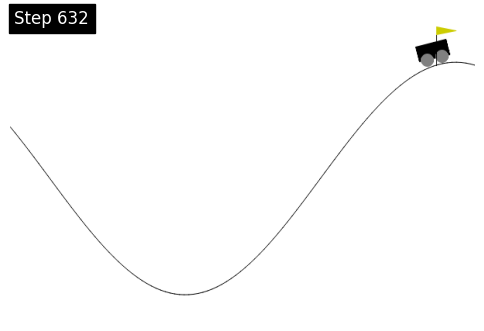

Saved visualization → output_gif/episode_1.gif
Finished visualization.


In [ ]:
#@title **Policy Visualization**
EPISODE_DIR = "episode_1"
LOGDIR = "logs/mountaincar_continuous_tutorial"

def run_policy(
    render_mode="rgb_array",
    logdir=LOGDIR,
    episode_dir=EPISODE_DIR,
    save_gif=False,
    fast_mode=True,
):

    if fast_mode:
        sleep_time = 0.01
        display_interval = 2
        downscale_factor = 1
    else:
        sleep_time = 0.05
        display_interval = 1
        downscale_factor = 1

    world = ContinualSpaceGeneralWorld(
        "MountainCarContinuous-v0",
        render_mode=render_mode,
        max_traj_length=MAX_TRAJ_LENGTH,
    )

    agent = LLMNumOptimAgent(
        logdir,
        dim_action=1,
        dim_state=2,
        max_traj_count=MAX_TRAJ_COUNT,
        max_traj_length=MAX_TRAJ_LENGTH,
        llm_si_template=llm_si_template,
        llm_output_conversion_template=llm_output_conversion_template,
        llm_model_name=LLM_MODEL_NAME,
        num_evaluation_episodes=NUM_EVALUATION_EPISODES,
        bias=None,
        optimum=100,
        search_step_size=SEARCH_STD,
    )

    param_path = os.path.join(logdir, episode_dir, "parameters.txt")
    if not os.path.exists(param_path):
        raise FileNotFoundError(f"Could not find parameter file at {param_path}")

    with open(param_path, "r") as f:
        lines = f.readlines()
        weights = [float(x.strip()) for x in lines[1:] if x.strip()]
    agent.policy.update_policy([weights])

    raw_state = world.reset()
    state = np.expand_dims(raw_state, axis=0)
    done = False
    step_idx = 0
    frames = [] if save_gif else None

    def get_frame():
        try:
            img = world.env.render()
        except Exception:
            try:
                img = world.env.render(mode="rgb_array")
            except Exception:
                img = None
        if img is None:
            try:
                img = world.render()
            except Exception:
                img = None
        return img

    img = get_frame()
    if img is None:
        raise RuntimeError("Unable to obtain an RGB frame from the environment.")

    if not isinstance(img, np.ndarray):
        img = np.array(img)
    if downscale_factor > 1:
        img = img[::downscale_factor, ::downscale_factor]

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(img)
    ax.axis("off")
    text_box = ax.text(5, 15, '', color='white', fontsize=12, backgroundcolor='black')
    display_id = f"policy_vis_{int(time.time()*1000)}"
    display(fig, display_id=display_id)

    while not done:
        img = get_frame()
        if img is None:
            print(f"Warning: got None frame at step {step_idx}")
            break

        if not isinstance(img, np.ndarray):
            img = np.array(img)
        if downscale_factor > 1:
            img = img[::downscale_factor, ::downscale_factor]

        im.set_data(img)
        text_box.set_text(f"Step {step_idx}")

        if step_idx % display_interval == 0:
            update_display(fig, display_id=display_id)

        if save_gif:
            frames.append(img.copy())

        try:
            action = agent.policy.get_action(state.T)
        except Exception as e:
            print(f"Error getting action at step {step_idx}: {e}")
            break

        action_np = np.asarray(action)
        if action_np.ndim == 0:
            action_np = np.reshape(action_np, (1, 1))
        elif action_np.ndim == 1:
            action_np = action_np.reshape(1, -1)
        elif action_np.ndim >= 2:
            action_np = action_np[0:1, :]

        try:
            next_state, reward, done = world.step(action_np)
        except Exception as e:
            try:
                next_state, reward, done = world.step(np.squeeze(action_np))
            except Exception as e2:
                print("Error stepping env:", e, e2)
                break

        state = np.expand_dims(next_state, 0) if next_state.ndim == 1 else next_state
        step_idx += 1
        time.sleep(sleep_time)

    plt.close(fig)

    if save_gif and frames:
      gif_dir = "output_gif"
      os.makedirs(gif_dir, exist_ok=True)  # <-- create folder if it doesn't exist
      gif_path = os.path.join(gif_dir, f"{episode_dir}.gif")
      imageio.mimsave(gif_path, frames, fps=max(1, int(1 / sleep_time)))
      print(f"Saved visualization → {gif_path}")

    print(f"Finished visualization.")

run_policy(save_gif=True, fast_mode=True)

In [ ]:
#@title **Episodes Reward Summary**
all_succ = []
root_folder = "logs/mountaincar_continuous_tutorial"

all_folders = [os.path.join(root_folder, x) for x in os.listdir(root_folder) if 'episode' in x]
all_folders.sort(key=lambda x: int(x.split('_')[-1]))
for folder in all_folders:
    # read all text files in the folder. Read the last line of each file and extract the total reward. The last line looks like this: "Total reward: -157.0"
    rewards_succ = []
    rewards_fail = []
    for filename in os.listdir(folder):
        if 'training' in filename:
            with open(os.path.join(folder, filename), 'r') as f:
                lines = f.readlines()
                rewards = []
                for line in lines:
                    if 'Total reward' in line:
                        total_reward = float(line.split()[-1])
                        rewards.append(total_reward)
                if rewards:  # prevent empty list
                    rewards_succ.append(np.mean(rewards))

    # Evaluation files (separate loop, not "else")
    curr_episode_rewards = []
    for filename in os.listdir(folder):
        if 'evaluation' in filename:
            with open(os.path.join(folder, filename), 'r') as f:
                lines = f.readlines()
                curr_rewards = []
                for line in lines[1:]:
                    try:
                        curr_rewards.append(float(line.split('|')[-1]))
                    except ValueError:
                        continue  # skip malformed lines
                if curr_rewards:
                    curr_episode_rewards.append(np.sum(curr_rewards))
    if curr_episode_rewards:
        rewards_succ.append(np.mean(curr_episode_rewards))

    # print(rewards_succ)
    # print(rewards_fail)


    all_rewards = rewards_succ + rewards_fail

    print("Average reward for all episodes:", np.mean(all_rewards))
    print("Standard deviation of reward for all episodes:", np.std(all_rewards))
    print("------------------")


    if 'descent' in root_folder:
        all_succ.append(1500 - np.mean(all_rewards))
    else:
        all_succ.append(np.mean(all_rewards))
# print(all_succ)
print(max(all_succ))
for i in range(len(all_succ)):
    if all_succ[i] >= max(all_succ) * 0.95:
        print(i + 1)
        break

Average reward for all episodes: -44.46642213865812
Standard deviation of reward for all episodes: 0.0
------------------
Average reward for all episodes: -9.762548575001407
Standard deviation of reward for all episodes: 0.0
------------------
Average reward for all episodes: 56.46273498605349
Standard deviation of reward for all episodes: 0.0
------------------
Average reward for all episodes: -133.1680597377453
Standard deviation of reward for all episodes: 0.0
------------------
Average reward for all episodes: -71.07276318997293
Standard deviation of reward for all episodes: 0.0
------------------
Average reward for all episodes: 69.68339827078572
Standard deviation of reward for all episodes: 0.0
------------------
Average reward for all episodes: 61.97491808440086
Standard deviation of reward for all episodes: 0.0
------------------
Average reward for all episodes: -32.5872735035865
Standard deviation of reward for all episodes: 0.0
------------------
Average reward for all episo

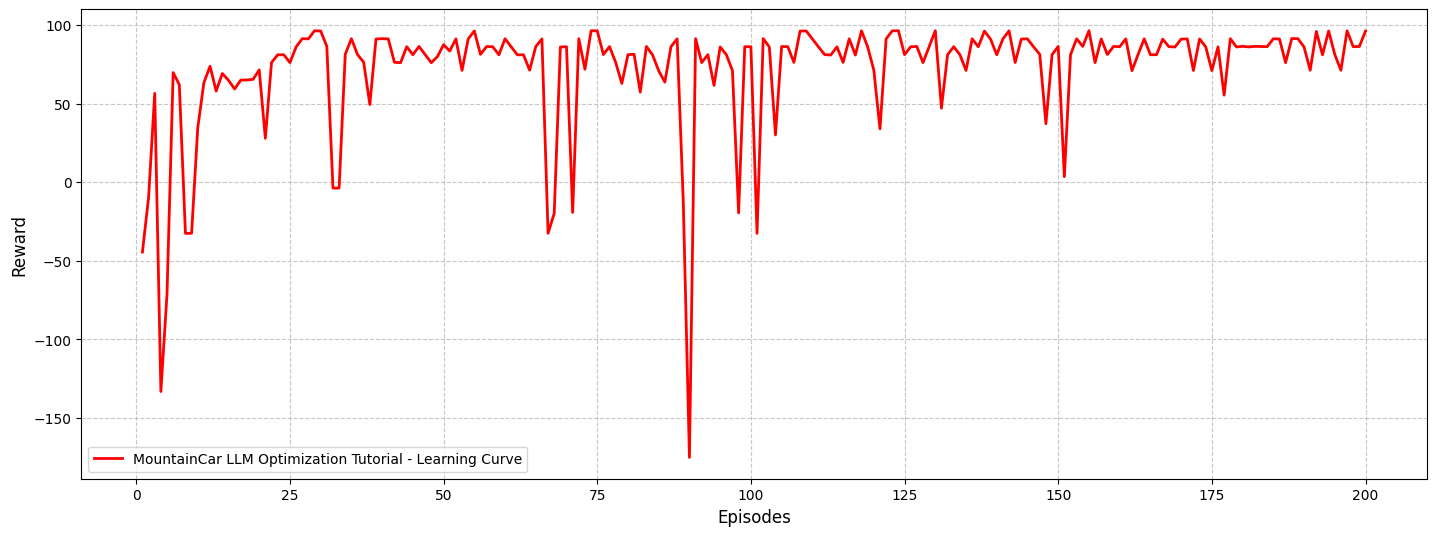

In [ ]:
#@title **Reward Curve**
episodes = list(range(1, len(all_succ) + 1))

# Creating the plot
plt.figure(figsize=(15, 6))

# Plot the main line with better styling
plt.plot(episodes, all_succ, linewidth=2, color='red', label="MountainCar LLM Optimization Tutorial - Learning Curve")

plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(pad=3.0)

os.makedirs('results_curves', exist_ok=True)
plt.savefig(f'results_curves/{root_folder.split("/")[1]}.png', dpi=300)
%matplotlib inline
plt.show()

The `Reward Curve` plotted over the training episodes illustrates the progressive improvement of the learned policy. Typically, in early stages of training, rewards fluctuate due to random initialization and broad exploration. As the LLM repeatedly refines the parameters, the curve begins to rise steadily, indicating that the model is discovering more effective control strategies. Eventually, the reward curve stabilizes, reflecting convergence toward a locally optimal linear policy for the environment.

## **Summary**
This demo illustrates how Large Language Models, within the Prompted Policy Search (ProPS) framework, can act as central reasoning engines for reinforcement learning by jointly leveraging linguistic and numerical cues. Rather than relying on gradient-based updates or analytic models of the environment, the LLM incrementally improves a linear control policy for the MountainCar environment using only the replayed history of policy parameters and their resulting rewards. By embedding the optimization goal, the replay buffer contents, and instructions for balancing exploration and exploitation directly into the prompt, the LLM is encouraged to infer the relationship between policy weights and episode returns—treating the environment as an opaque black-box function. Over successive episodes, the model uses in-context learning to identify promising parameter directions, refining its estimates purely from observed outcomes and natural-language guidance.

Beyond the MountainCar example, the ProPS methodology generalizes to a broad class of reinforcement learning problems. Because policy updates are communicated and reasoned about through prompt structure rather than backpropagation or explicit gradient computation, LLMs can flexibly integrate reward feedback, natural-language constraints, and high-level instructions in a unified optimization loop. This demonstration highlights how ProPS enables LLMs to participate directly in policy search, showing how linguistic reasoning can complement numerical reasoning to drive self-improvement in simulated control environments.

## **Conclusion**
This demonstration shows that LLMs can serve as effective policy optimizers in reinforcement learning when guided through structured prompts, capturing the core insight of the ProPS framework. Without access to transition dynamics, reward functions, or gradient information, the LLLM learns to propose increasingly effective policy parameters by interpreting replay-buffer histories and adapting its search strategy over time. Although the LLM is not performing classical RL computation internally, its ability to approximate improved policy updates based solely on contextual feedback validates the ProPS claim that language-based reasoning can drive policy search.

ProPS provides an interpretable and flexible mechanism for integrating LLMs into reinforcement-learning loops. Through carefully designed prompts and iterative interaction with the environment, the LLM progressively discovers high-reward policies—demonstrating that linguistic and numerical reasoning, when fused inside a single model, offer a practical pathway for optimizing control behavior in continuous-action domains.

<br>

For more details, please refer to the [ProPS Project Page](https://props-llm.github.io/) and the associated research paper.


## **References**
Zhou, Y., Grover, S., El Mistiri, M., Kalirathnam, K., Kerhalkar, P., Mishra, S., Kumar, N., Gaurav, S., Aran, O., & Ben Amor, H. (2025). Prompted Policy Search: Reinforcement Learning through Linguistic and Numerical Reasoning in LLMs, Advances in Neural Information Processing Systems (NeurIPS 2025).